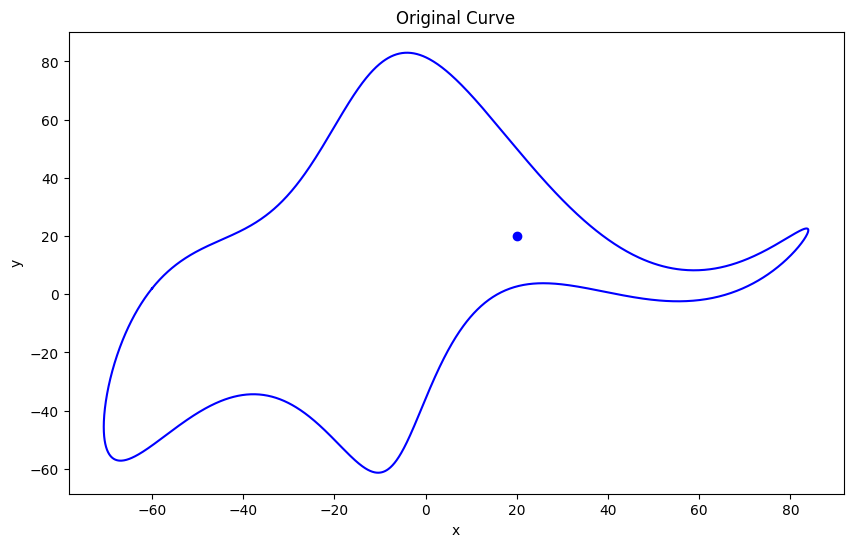

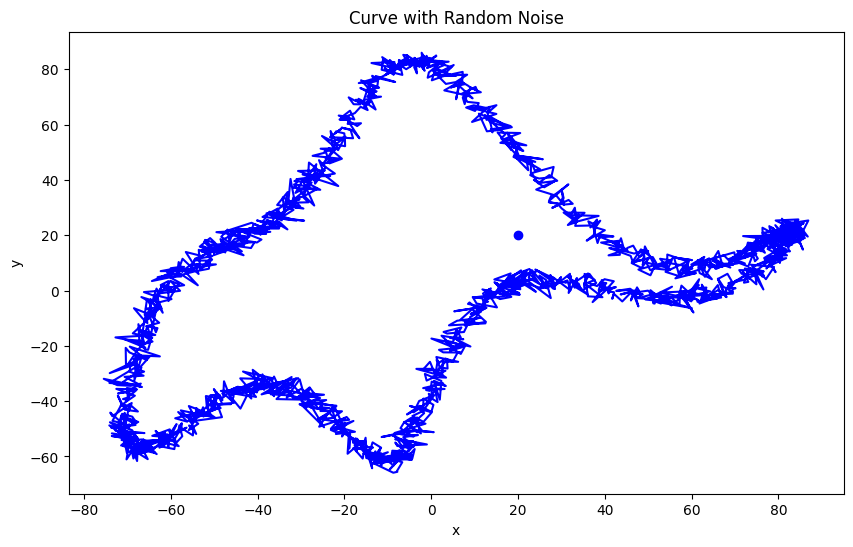

19/19 [==============================] - 0s 3ms/step
Mean Squared Error: 7.412553161274443
63/63 [==============================] - 0s 4ms/step


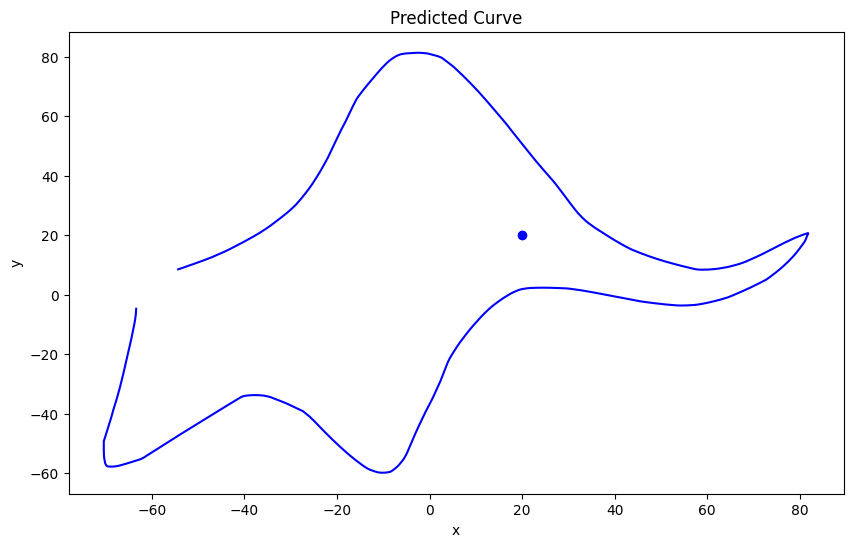

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import HeNormal

# Constants
NUM_RECORDS = 2000
T_VALUES = np.linspace(0, 2 * np.pi, NUM_RECORDS)
EYE_POINT = (20, 20)

def create_curve(t_values):
    # Calculate x and y values based on the provided equations
    x_values = -60 * np.cos(t_values) - 30 * np.sin(t_values) + 8 * np.sin(2 * t_values) - 10 * np.sin(3 * t_values)
    y_values = -50 * np.sin(t_values) - 18 * np.sin(2 * t_values) - 12 * np.cos(3 * t_values) + 14 * np.cos(5 * t_values)
    return x_values, y_values

def plot_curve(x_values, y_values, title='Curve', scatter_curve=None):
    plt.figure(figsize=(10, 6))
    if scatter_curve is not None:
        x_scatter, y_scatter = scatter_curve
        plt.plot(x_scatter, y_scatter, color='orange')
    plt.plot(x_values, y_values, color='blue')
    plt.scatter(*EYE_POINT, color='blue', zorder=5, marker='o')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def add_noise(x_values, y_values, std_dev=2):
    noise_x = np.random.normal(0, std_dev, len(x_values))
    noise_y = np.random.normal(0, std_dev, len(y_values))
    return x_values + noise_x, y_values + noise_y

def prepare_data(t_values, x_values, y_values, test_size=0.3, random_state=42):
    data = np.column_stack((t_values, x_values, y_values))
    X = data[:, 0].reshape(-1, 1)  # Explanatory variable (t)
    y = data[:, 1:]  # Dependent variables (x and y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def normalize_data(scaler, X_train, X_test):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def build_model(input_dim):
    model = Sequential([
        Dense(1024, input_dim=input_dim, kernel_initializer=HeNormal(), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(256, kernel_initializer=HeNormal(), activation=LeakyReLU(alpha=0.01)),
        Dense(2)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

def train_model(model, X_train, y_train, early_stopping, epochs=2000, batch_size=16, validation_split=0.3):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=validation_split, callbacks=[early_stopping])
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    return mse

# Original curve
x_values, y_values = create_curve(T_VALUES)
plot_curve(x_values, y_values, title='Original Curve')

# Curve with noise
x_values_noisy, y_values_noisy = add_noise(x_values, y_values)
plot_curve(x_values_noisy, y_values_noisy, title='Curve with Random Noise')

# Prepare and normalize data
scaler = StandardScaler()
X_train, X_test, y_train, y_test = prepare_data(T_VALUES, x_values_noisy, y_values_noisy)
X_train_scaled, X_test_scaled = normalize_data(scaler, X_train, X_test)

# Build, train, and evaluate the model
model = build_model(input_dim=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
train_model(model, X_train_scaled, y_train, early_stopping)
evaluate_model(model, X_test_scaled, y_test)

# Predict and plot the entire dataset
X_all_normalized = scaler.transform(T_VALUES.reshape(-1, 1))
predicted_values = model.predict(X_all_normalized)
predicted_x_values = predicted_values[:, 0]
predicted_y_values = predicted_values[:, 1]
plot_curve(predicted_x_values, predicted_y_values, title='Predicted Curve')
